In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(cowplot)
    library(ggrepel)
    library(pheatmap)
})
theme_set(theme_cowplot())
options(repr.plot.width=9,repr.plot.height=7)

# Practical Guide to PCA visualization in R

This guide illustrates how to visualize the results of a PCA analysis

There is a sister notebook to this one in Python here: [](pca-visualization-in-python.ipynb)

# Dataset

In [2]:
# iris dataset is part of R base
head(iris,5)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


# Run a PCA decomposition

In [3]:
iris.data = select(iris, -Species)
pca_res = prcomp(iris.data)
dim(pca_res$x)

[1] 150   4

# Scatter plot of observations

Observations are projected on the first 2 components

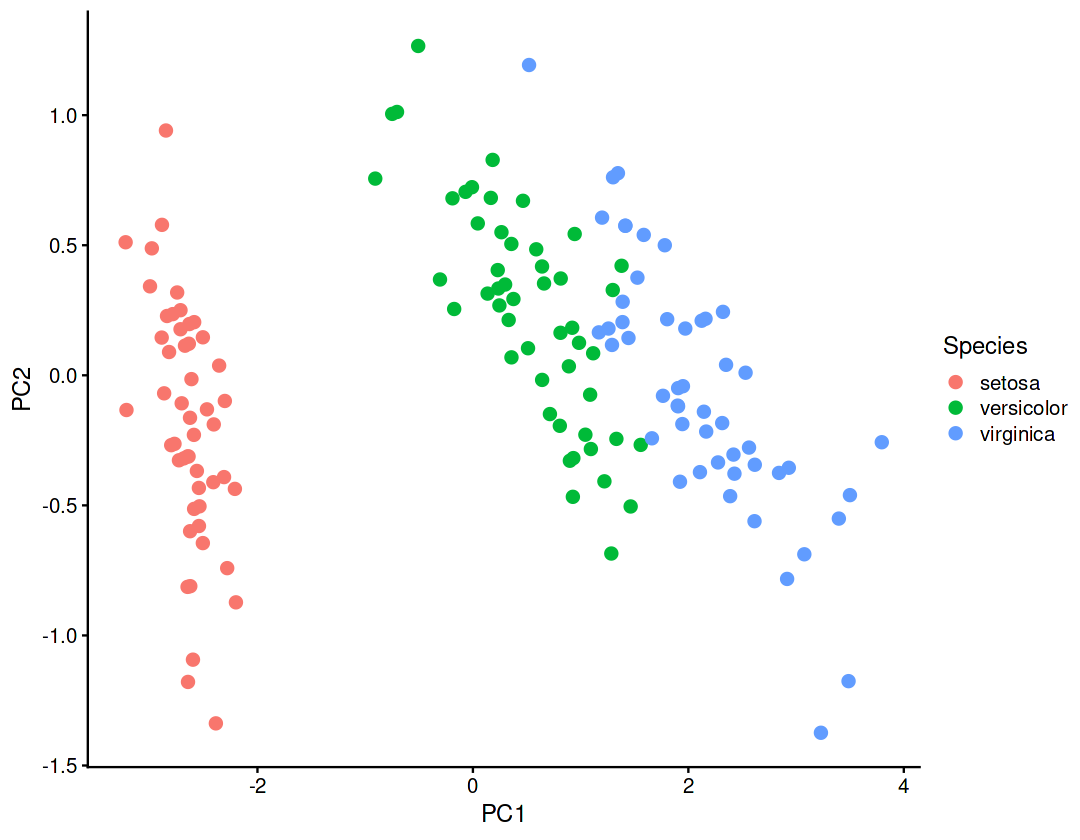

In [4]:
pca_res$x %>% 
bind_cols(select(iris, Species)) %>%
ggplot(aes(x=PC1, y=PC2, color=Species)) + geom_point(size=3)

# Explained variance (eigenvalues)

The amount of variance explained by each of the components

In [5]:
var = pca_res$sdev ** 2
var

[1] 4.22824171 0.24267075 0.07820950 0.02383509

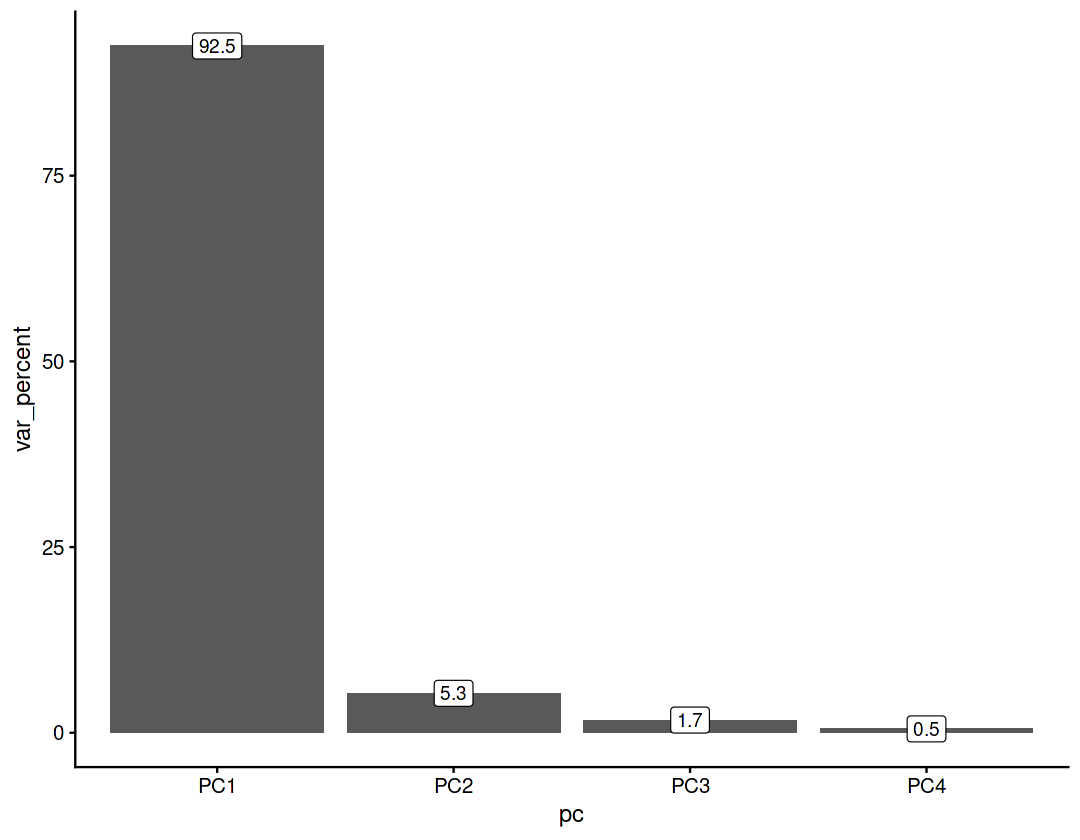

In [6]:
tibble(var_percent=100*var/sum(var),pc=colnames(pca_res$x)) %>%
ggplot(aes(x=pc, y=var_percent)) +
geom_col() +
geom_label(aes(label=round(var_percent,1)))

# Cumulative variance

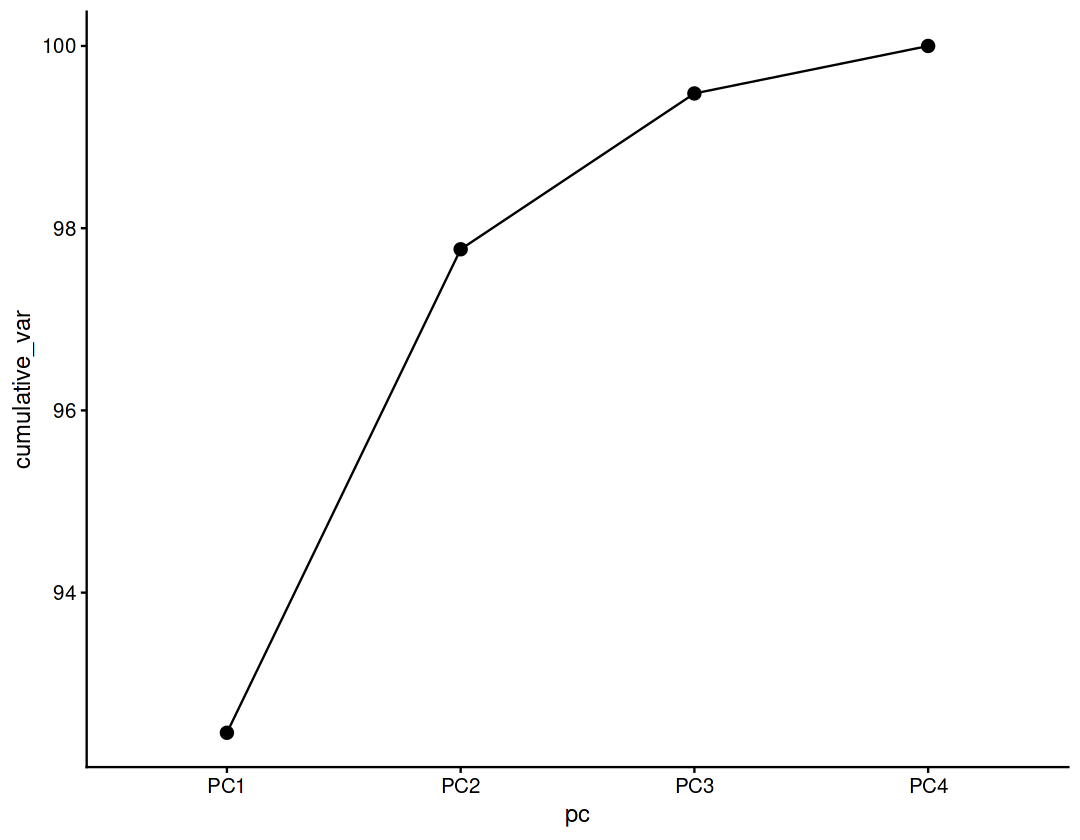

In [7]:
tibble(var_percent=100*var/sum(var),pc=colnames(pca_res$x)) %>%
mutate(cumulative_var=cumsum(var_percent)) %>%
ggplot(aes(x=pc, y=cumulative_var,group=1)) +
geom_point(size=3) +
geom_line()

# Component rotations (eigenvectors)

Principal axes in feature space, representing the directions of maximum variance in the data

In [8]:
pca_res$rotation

,PC1,PC2,PC3,PC4
Sepal.Length,0.36138659,-0.65658877,0.58202985,0.3154872
Sepal.Width,-0.08452251,-0.73016143,-0.59791083,-0.3197231
Petal.Length,0.85667061,0.17337266,-0.07623608,-0.4798390
Petal.Width,0.35828920,0.07548102,-0.54583143,0.7536574


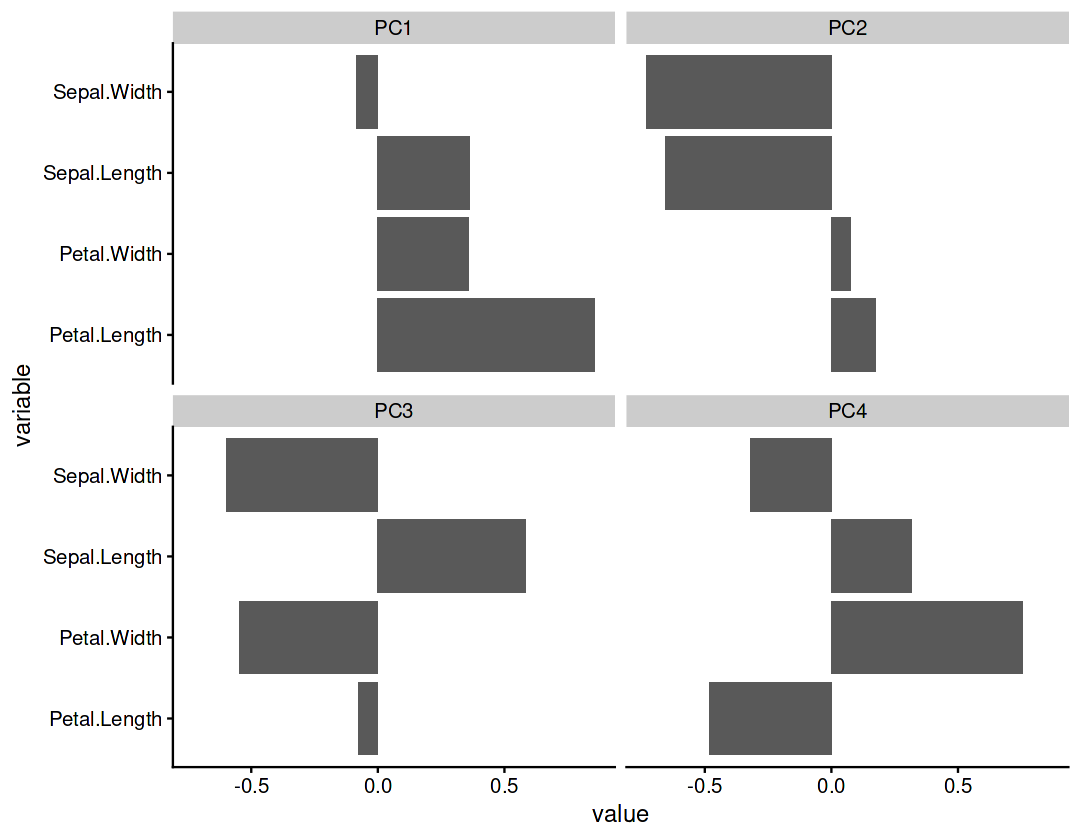

In [9]:
pca_res$rotation %>% 
as.data.frame() %>%
rownames_to_column('variable') %>%
pivot_longer(names_to = 'pc', values_to = 'value', -variable) %>%
ggplot(aes(y=variable, x=value)) + geom_col() + facet_wrap(~pc)

# Component loadings

Eigenvectors scaled by the square root of the eigenvalues

In [10]:
var_cor = t(pca_res$rotation) * pca_res$sdev
var_cor

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
PC1,0.74310800,-0.17380102,1.76154511,0.73673893
PC2,-0.32344628,-0.35968937,0.08540619,0.03718318
PC3,0.16277024,-0.16721151,-0.02132015,-0.15264701
PC4,0.04870686,-0.04936083,-0.07408051,0.11635429


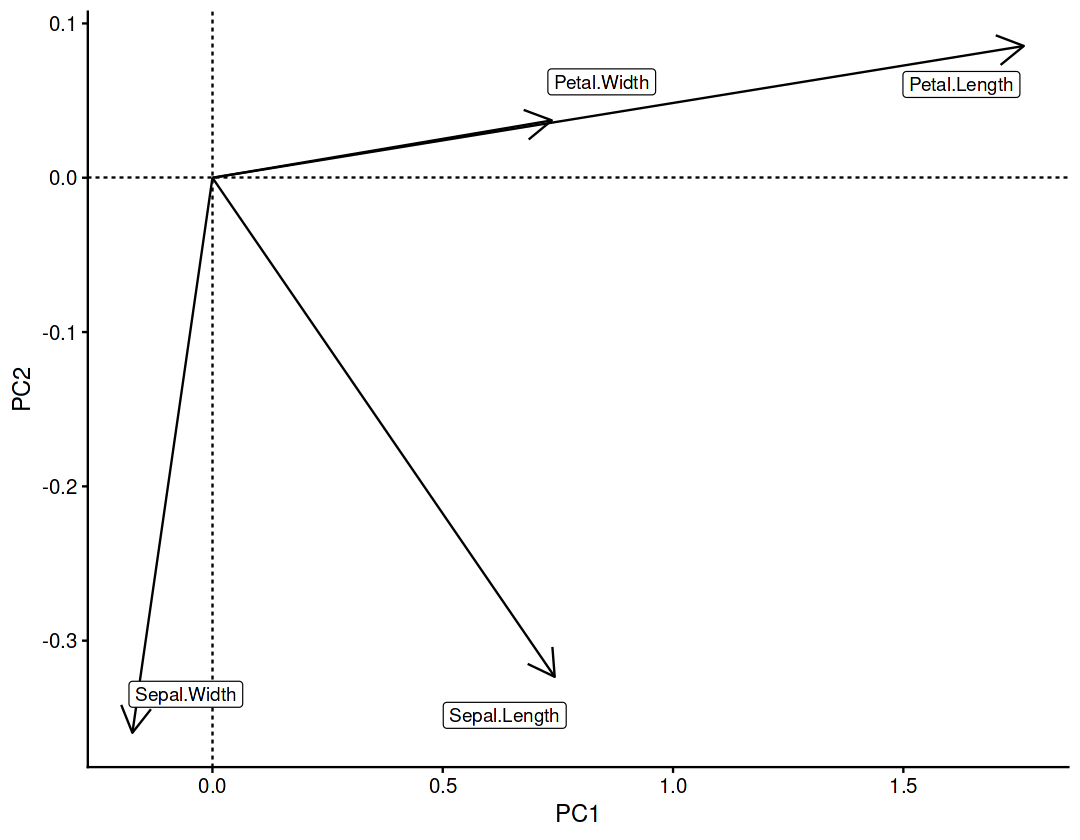

In [11]:
m = max(abs(var_cor))
t(var_cor) %>% 
as.data.frame() %>% 
rownames_to_column('var') %>%
ggplot(aes(x=PC1, y=PC2)) + 
geom_segment(arrow=arrow(),aes(x=0,y=0,xend=PC1,yend=PC2)) +
geom_vline(xintercept=0, linetype=2) +
geom_hline(yintercept=0, linetype=2) +
geom_label_repel(aes(label=var),box.padding = 1, min.segment.length = Inf)

# Component contributions

Measures the contribution of the variables to each component

In [12]:
var_cos2 = var_cor ** 2
var_contrib = (100 * var_cos2) / rowSums(var_cos2)
var_contrib

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
PC1,13.060027,0.7144055,73.3884527,12.8371149
PC2,43.110881,53.3135721,3.0058080,0.5697384
PC3,33.875875,35.7497361,0.5811939,29.7931952
PC4,9.953217,10.2222863,23.0245453,56.7999515


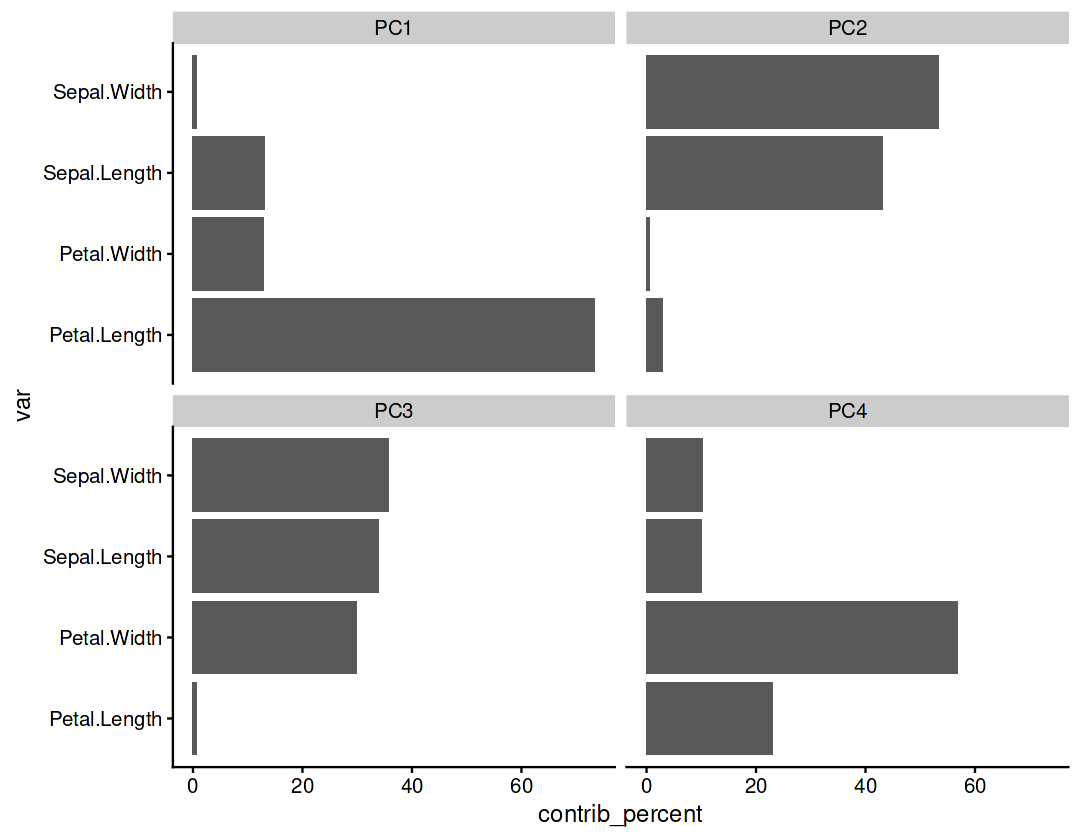

In [13]:
var_contrib %>% 
as.data.frame() %>%
rownames_to_column('pc') %>%
pivot_longer(names_to = 'var', values_to = 'contrib_percent', -pc) %>%
ggplot(aes(y=var, x=contrib_percent)) + geom_col() + facet_wrap(~pc)

# Correlation of all variables

Compare the correlations with the components loadings found by PCA

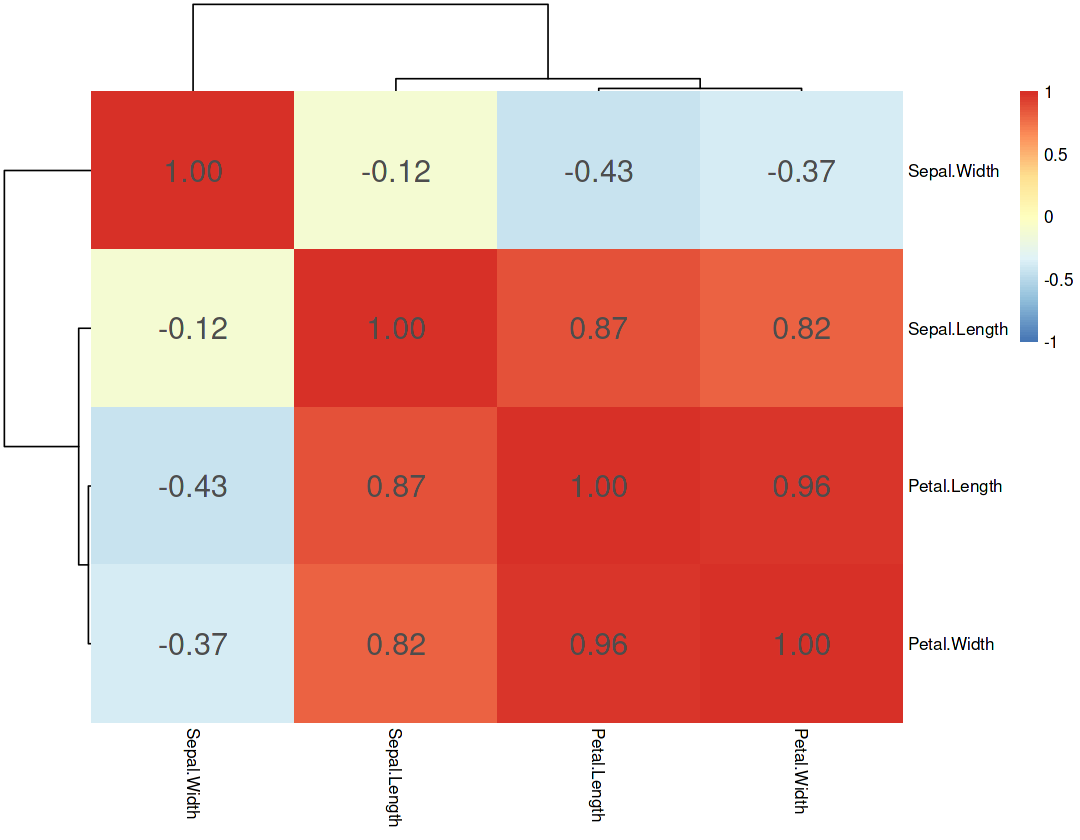

In [14]:
cor(iris.data) %>% 
pheatmap(display_numbers = TRUE, border_color = NA, fontsize_number = 18, breaks = seq(-1,1,length.out = 101))